In [23]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [24]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=60,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


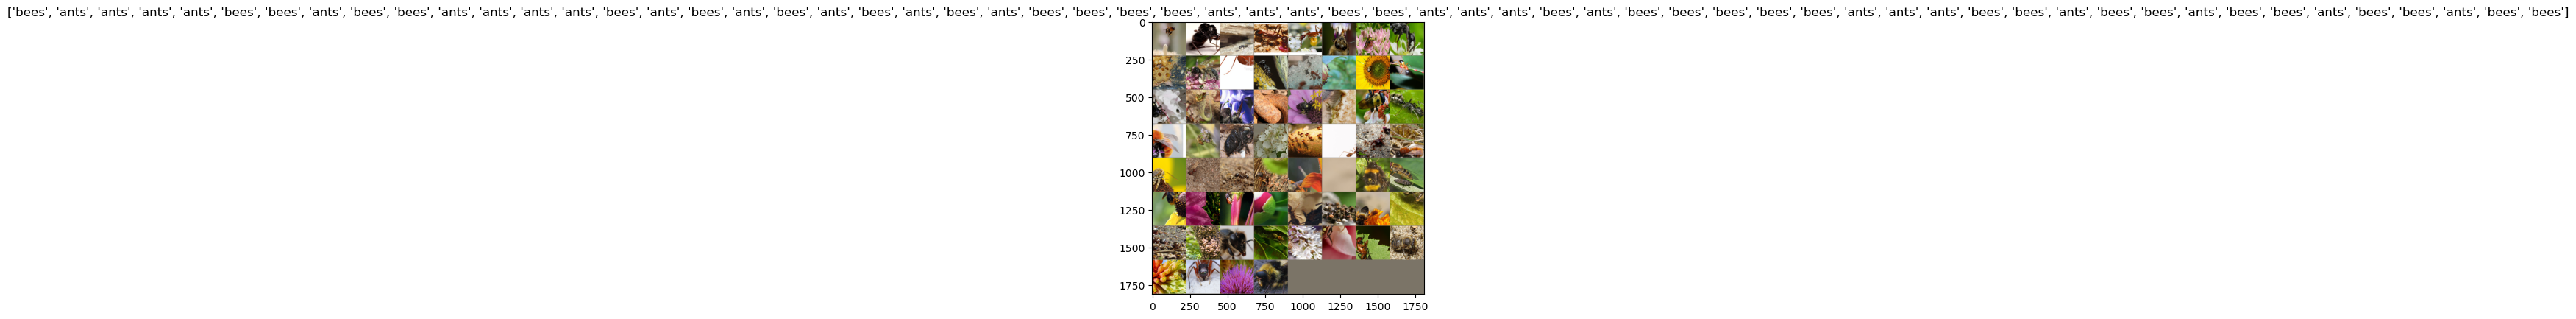

In [25]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Reference
---------------------
[Transfer Learning for Computer Vision Tutorial],
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`,
`cs231n notes <https://cs231n.github.io/transfer-learning/>`


Training
========
To load dataset with different size, change the batch_size on code block 3.

In [26]:
inputs, classes = next(iter(dataloaders['train']))
tests, test_classes = next(iter(dataloaders['val']))

print(inputs.shape)
print(tests.shape)

torch.Size([60, 3, 224, 224])
torch.Size([60, 3, 224, 224])


SVM
===

In [27]:
from sklearn import svm
# Flatten each image (3, 224, 224) to a 1D array (150528)

inputs_flattened = inputs.reshape(60, -1)
tests_flattened = tests.reshape(len(tests), -1)


clf = svm.SVC(gamma=0.05)

# Learn the digits on the train subset
clf.fit(inputs_flattened, classes)

# Predict the value of the digit on the test subset
predicted = clf.predict(tests_flattened )




In [28]:

from sklearn.metrics import accuracy_score
accuracy_score(test_classes, predicted)
print(f"Accuracy: {accuracy_score(test_classes, predicted)}")

Accuracy: 0.43333333333333335


K-nn
====

In [29]:
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=10)
knn.fit(inputs_flattened, classes)
predicted = knn.predict(tests_flattened)
print(f"Accuracy: {accuracy_score(test_classes, predicted)}")

Accuracy: 0.48333333333333334


SVM with PCA
============

In [30]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Flatten the input tensors
lin_inputs = inputs.view(inputs.size(0), -1).cpu().numpy()
lin_tests = tests.view(tests.size(0), -1).cpu().numpy()

# Scale the data
scaler = StandardScaler()
lin_inputs = scaler.fit_transform(lin_inputs)
lin_tests = scaler.transform(lin_tests)

# Apply PCA
pca = PCA(n_components=50) # Choose the number of components
lin_inputs = pca.fit_transform(lin_inputs)
lin_tests = pca.transform(lin_tests)

# Train the SVM classifier
clf = svm.SVC()
clf.fit(lin_inputs, classes.cpu().numpy())

# Predict on the validation set
predicted = clf.predict(lin_tests)

# Evaluate the model (example using accuracy)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_classes.cpu().numpy(), predicted)
print(f"Accuracy of SVM with PCA: {accuracy}")

Accuracy of SVM with PCA: 0.48333333333333334


K-nn with PCA
=============

In [31]:
from sklearn import neighbors

pca = PCA(n_components=50) # Choose the number of components
lin_inputs = pca.fit_transform(lin_inputs)
lin_tests = pca.transform(lin_tests)

knn = neighbors.KNeighborsClassifier(n_neighbors=10)
knn.fit(lin_inputs, classes)
predicted = knn.predict(lin_tests)
print(f"Accuracy: {accuracy_score(test_classes, predicted)}")

Accuracy: 0.5


Load Pre-trained CNN model
==========================

In [33]:

# Load pretrained ResNet18 model
model = models.resnet18(pretrained=True)

# Adjust the final layer to match the number of classes (2 for Bee and Ant)
num_classes = len(class_names)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to the appropriate device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    print("-" * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()  # Set model to evaluation mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward pass and optimization only in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate epoch loss and accuracy
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

print("Training complete.")

Epoch 1/5
----------
Train Loss: 0.4787 Acc: 0.7705
Val Loss: 7.1120 Acc: 0.5686
Epoch 2/5
----------
Train Loss: 0.5335 Acc: 0.8402
Val Loss: 20.4442 Acc: 0.5490
Epoch 3/5
----------
Train Loss: 0.4567 Acc: 0.8156
Val Loss: 5.8665 Acc: 0.7516
Epoch 4/5
----------
Train Loss: 0.4420 Acc: 0.7951
Val Loss: 19.2307 Acc: 0.5556
Epoch 5/5
----------
Train Loss: 0.4192 Acc: 0.8033
Val Loss: 2.6874 Acc: 0.7386
Training complete.


SVM and Knn with feature extractor of pre-trained CNN
================

In [37]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np

# Load Pretrained CNN (ResNet18)
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Identity()  # Replace the final layer with an identity layer to extract features
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Data Transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load Dataset
data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(f"{data_dir}/{x}", transform=data_transforms) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=False) for x in ['train', 'val']}

# Extract Features
def extract_features(dataloader, model):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu().numpy()
            features.append(outputs)
            labels.append(targets.numpy())
    return np.vstack(features), np.hstack(labels)

train_features, train_labels = extract_features(dataloaders['train'], model)
val_features, val_labels = extract_features(dataloaders['val'], model)


In [39]:
# Standardize features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
val_features_scaled = scaler.transform(val_features)

# Train SVM
svm = SVC(kernel='linear', C=1.0)
svm.fit(train_features_scaled, train_labels)

# Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_features_scaled, train_labels)

# Evaluate SVM
svm_predictions = svm.predict(val_features_scaled)
svm_accuracy = accuracy_score(val_labels, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy:.4f}")

# Evaluate KNN
knn_predictions = knn.predict(val_features_scaled)
knn_accuracy = accuracy_score(val_labels, knn_predictions)
print(f"KNN Accuracy: {knn_accuracy:.4f}")


SVM Accuracy: 0.9216
KNN Accuracy: 0.9150


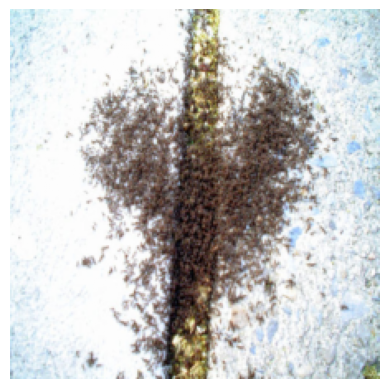

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].


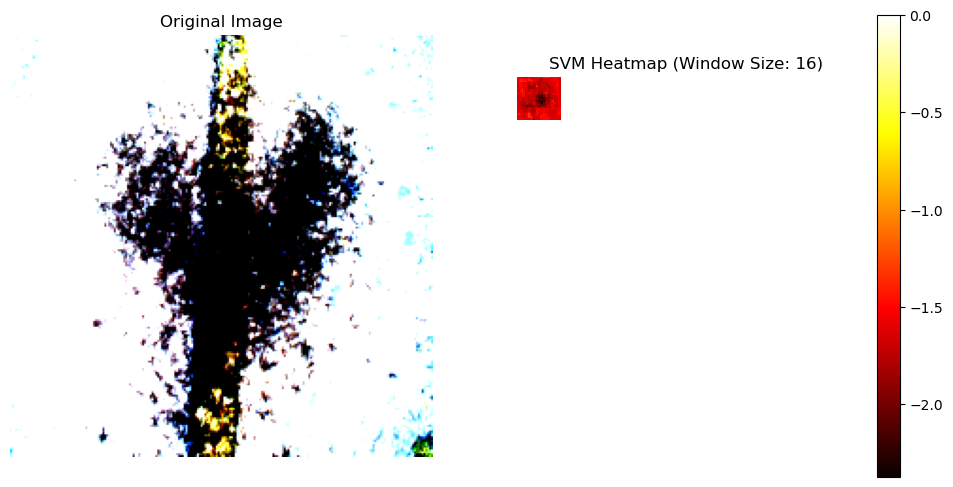

In [45]:
def sliding_perturbation(image, model, classifier, scaler, window_size, step_size):
    """
    Apply sliding perturbation to the image with a given window size and step size.
    """
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    image = image.unsqueeze(0).to(device)  # Add batch dimension

    height, width = image.shape[2], image.shape[3]
    heatmap = np.zeros((height - window_size + 1, width - window_size + 1))

    with torch.no_grad():
        for i in range(0, height - window_size + 1, step_size):
            for j in range(0, width - window_size + 1, step_size):
                # Create a perturbed copy of the image
                perturbed_image = image.clone()
                perturbed_image[:, :, i:i + window_size, j:j + window_size] = 0  # Zero out the region

                # Extract features from the perturbed image
                features = model(perturbed_image).cpu().numpy()

                # Scale the features
                features_scaled = scaler.transform(features)

                # Get the prediction score from the classifier (e.g., SVM decision function)
                prediction_score = classifier.decision_function(features_scaled)[0]
                heatmap[i // step_size, j // step_size] = prediction_score

    return heatmap
def denormalize_and_visualize(image):
    # De-normalize the image
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = image.cpu() * std + mean  # Reverse normalization

    # Clip values to the range [0, 1]
    image = torch.clamp(image, 0, 1)

    # Convert to numpy and display
    plt.imshow(image.permute(1, 2, 0).numpy())  # CHW -> HWC
    plt.axis("off")
    plt.show()

# Apply to your test image

import matplotlib.pyplot as plt

# Select a single test image
test_iter = iter(dataloaders['val'])
test_image, test_label = next(test_iter)
test_image = test_image.squeeze(0)  # Remove batch dimension
denormalize_and_visualize(test_image)

# Generate heatmap with SVM
window_size = 16
step_size = 8
heatmap_svm = sliding_perturbation(test_image, model, svm, scaler, window_size, step_size)

# Plot original image and heatmap
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(test_image.permute(1, 2, 0).numpy())  # Convert CHW to HWC
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(heatmap_svm, cmap='hot', interpolation='nearest')
plt.title("SVM Heatmap (Window Size: 16)")
plt.colorbar()
plt.axis("off")

plt.show()



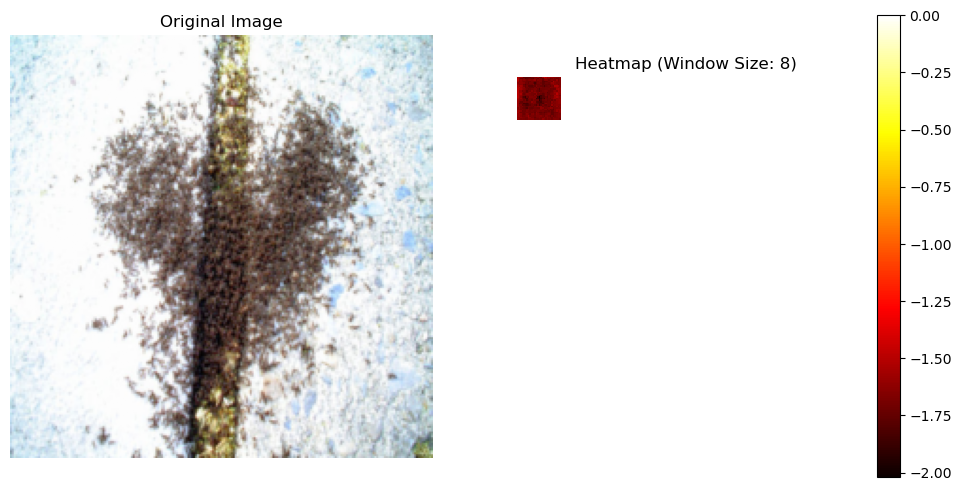

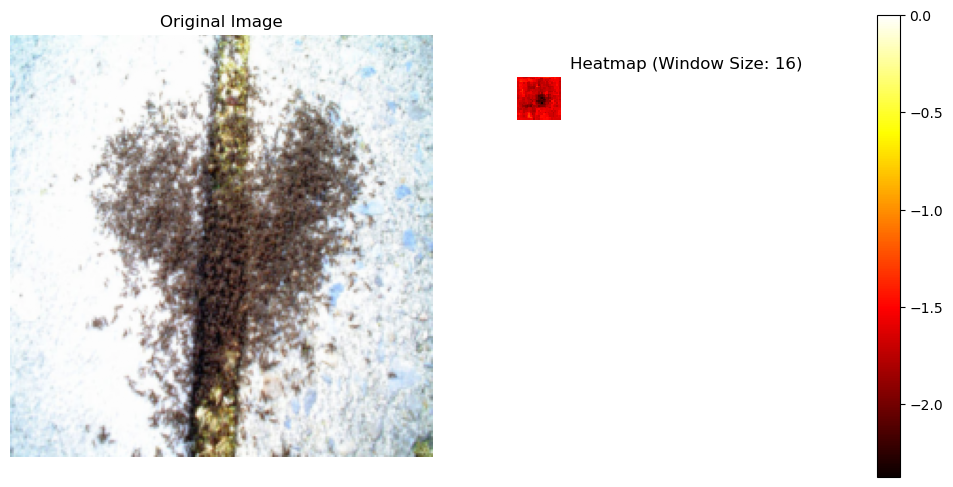

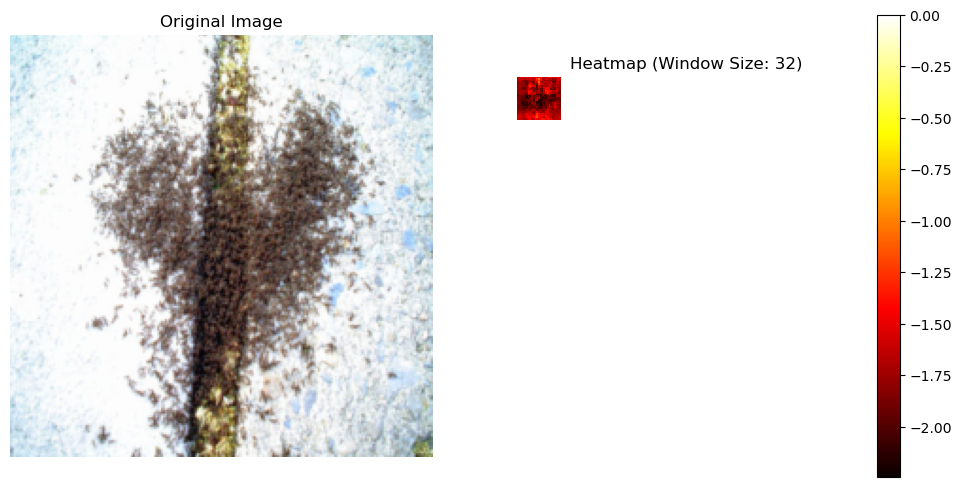

In [48]:
def denormalize(image):
    """
    De-normalize an image for visualization.
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = image.cpu() * std + mean  # Reverse normalization
    image = torch.clamp(image, 0, 1)  # Clip values to [0, 1]
    return image
# Generate heatmaps for different window sizes
for window_size in [8, 16, 32]:
    heatmap = sliding_perturbation(test_image, model, svm, scaler, window_size, step_size=8)

    # Plot the original test image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(denormalize(test_image).permute(1, 2, 0).numpy())  # CHW to HWC
    plt.title("Original Image")
    plt.axis("off")

    # Plot the heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap, cmap='hot', interpolation='nearest')
    plt.title(f"Heatmap (Window Size: {window_size})")
    plt.colorbar()
    plt.axis("off")

    plt.show()
